In [ ]:
# STEP 1: Upload your service account JSON key
from google.colab import files
uploaded = files.upload()  # Upload the JSON file (e.g., onion11-key.json)

# STEP 2: Move the uploaded file and authenticate GCP
import os

json_filename = list(uploaded.keys())[0]  # Get uploaded JSON filename
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_filename
print(f"Using service account: {json_filename}")

# STEP 3: Download dataset from GCS using gsutil
GCS_URI = "gs://onion11"
!mkdir -p OnionData
!gsutil -m cp -r {GCS_URI}/* OnionData/

Streaming output truncated to the last 5000 lines.
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0

In [ ]:
# STEP 4: Set up data directories and split into train/val/test
import os
import shutil
import random
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base folder containing all .jpg and .txt files
base_dir = 'OnionData'

# Optional: parse class index to name mapping from classes.txt
class_id_to_name = {}
classes_txt_path = os.path.join(base_dir, 'classes.txt')
if os.path.exists(classes_txt_path):
    with open(classes_txt_path, 'r') as f:
        for i, line in enumerate(f):
            class_id_to_name[str(i)] = line.strip()

# Get all base names with both .jpg and .txt present
jpgs = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.jpg')}
txts = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.txt')}

paired = [base for base in jpgs if base in txts]

print(f"Found {len(paired)} valid image-label pairs.")

# Group images by class
class_to_images = {}

for base in paired:
    txt_path = os.path.join(base_dir, txts[base])
    try:
        with open(txt_path, 'r') as f:
            line = f.readline().strip()
            if not line:
                continue
            class_id = line.split()[0]  # First token is class index
            class_label = class_id_to_name.get(class_id, f"class_{class_id}")  # Optional mapping
            if class_label not in class_to_images:
                class_to_images[class_label] = []
            class_to_images[class_label].append(jpgs[base])
    except Exception as e:
        print(f"Skipping {txt_path} due to error: {e}")

# Prepare train, val, test directories
for split in ['train', 'val', 'test']:
    shutil.rmtree(split, ignore_errors=True)
    for label in class_to_images.keys():
        os.makedirs(os.path.join(split, label), exist_ok=True)

# Split and copy images
for label, images in class_to_images.items():
    random.shuffle(images)
    total = len(images)
    train_n = int(0.8 * total)
    val_n = int(0.1 * total)
    test_n = total - train_n - val_n

    for img in images[:train_n]:
        shutil.copyfile(os.path.join(base_dir, img), os.path.join('train', label, img))
    for img in images[train_n:train_n+val_n]:
        shutil.copyfile(os.path.join(base_dir, img), os.path.join('val', label, img))
    for img in images[train_n+val_n:]:
        shutil.copyfile(os.path.join(base_dir, img), os.path.join('test', label, img))

# Show final stats
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}")
    for label in sorted(class_to_images.keys()):
        count = len(os.listdir(os.path.join(split, label)))
        print(f"  {label}: {count} images")


Found 1086 valid image-label pairs.

TRAIN
  Anthracnose: 244 images
  Basal_Rot: 10 images
  Iris_Yellow_Spot_Virus: 191 images
  Purple_Blotch: 80 images
  Stemphylium_Blight: 109 images
  Thrips: 232 images

VAL
  Anthracnose: 30 images
  Basal_Rot: 1 images
  Iris_Yellow_Spot_Virus: 23 images
  Purple_Blotch: 10 images
  Stemphylium_Blight: 13 images
  Thrips: 29 images

TEST
  Anthracnose: 31 images
  Basal_Rot: 2 images
  Iris_Yellow_Spot_Virus: 25 images
  Purple_Blotch: 10 images
  Stemphylium_Blight: 15 images
  Thrips: 30 images


In [ ]:
# STEP 5: Data loading and augmentation
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'train', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    'val', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    'test', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

print("Detected classes:", train_generator.class_indices)


Found 866 images belonging to 6 classes.
Found 106 images belonging to 6 classes.
Found 113 images belonging to 6 classes.
Detected classes: {'Anthracnose': 0, 'Basal_Rot': 1, 'Iris_Yellow_Spot_Virus': 2, 'Purple_Blotch': 3, 'Stemphylium_Blight': 4, 'Thrips': 5}


In [ ]:
# STEP 6: Define CoatNet-like model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def coatnet_block(x, filters):
    x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    return x

def build_coatnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = coatnet_block(inputs, 64)
    x = coatnet_block(x, 128)
    x = coatnet_block(x, 256)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax")(x)
    return Model(inputs, x)

input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = len(train_generator.class_indices)

model = build_coatnet(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,283,654 (4.90 MB)

 Trainable params: 1,281,862 (4.89 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# STEP 7: Train model
import time
EPOCHS = 10

start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)
training_time = time.time() - start_time


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.4983 - loss: 1.3261 - val_accuracy: 0.2736 - val_loss: 1.7826
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.7302 - loss: 0.7397 - val_accuracy: 0.2736 - val_loss: 1.8639
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.8133 - loss: 0.5377 - val_accuracy: 0.2736 - val_loss: 2.1691
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.7832 - loss: 0.5680 - val_accuracy: 0.2736 - val_loss: 2.7710
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.8254 - loss: 0.4776 - val_accuracy: 0.2736 - val_loss: 3.1851
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.8017 - loss: 0.4733 - val_accuracy: 0.2736 - val_loss: 4.2976
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.8221 - loss: 0.4429 - val_accuracy: 0.2736 - val_loss: 5.2336
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.8490 - loss: 0.4054 - val_accuracy: 0.2736 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.3537 - loss: 4.0970


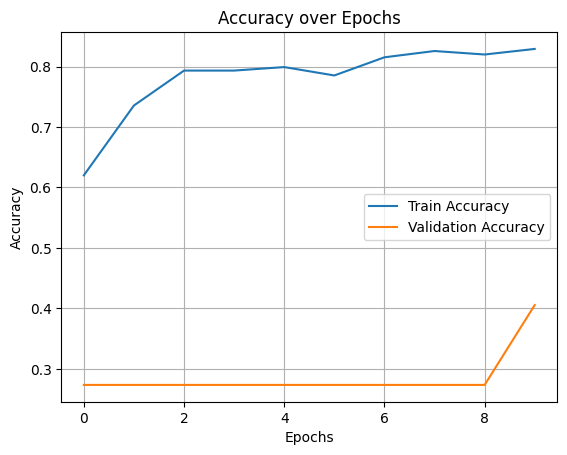

In [ ]:
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(test_generator)

# Accuracy curves
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.grid(True)
plt.show()



✅ Training Accuracy: 82.91%
✅ Validation Accuracy: 40.57%
✅ Test Accuracy: 38.94%
⏱️ Training Time: 1185.43 seconds
📦 Model Size: 4.89 MB
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step

📊 Classification Report:
                        precision    recall  f1-score   support

           Anthracnose       0.00      0.00      0.00        31
             Basal_Rot       0.00      0.00      0.00         2
Iris_Yellow_Spot_Virus       0.23      0.84      0.36        25
         Purple_Blotch       0.00      0.00      0.00        10
    Stemphylium_Blight       0.00      0.00      0.00        15
                Thrips       0.38      0.27      0.31        30

              accuracy                           0.26       113
             macro avg       0.10      0.18      0.11       113
          weighted avg       0.15      0.26      0.16       113



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


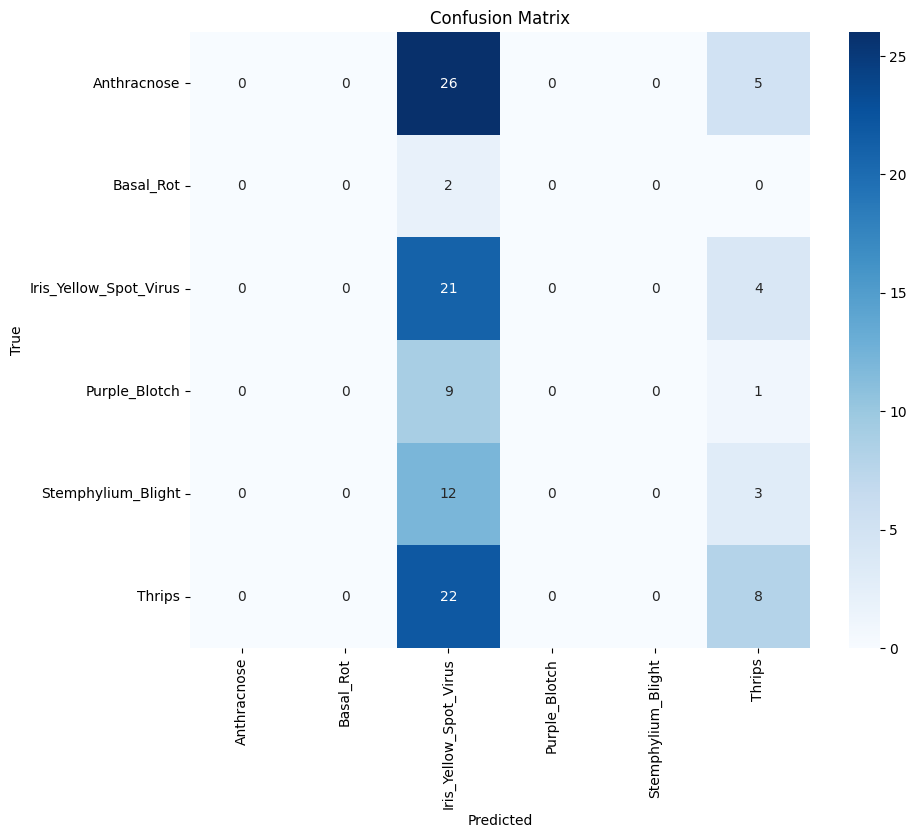

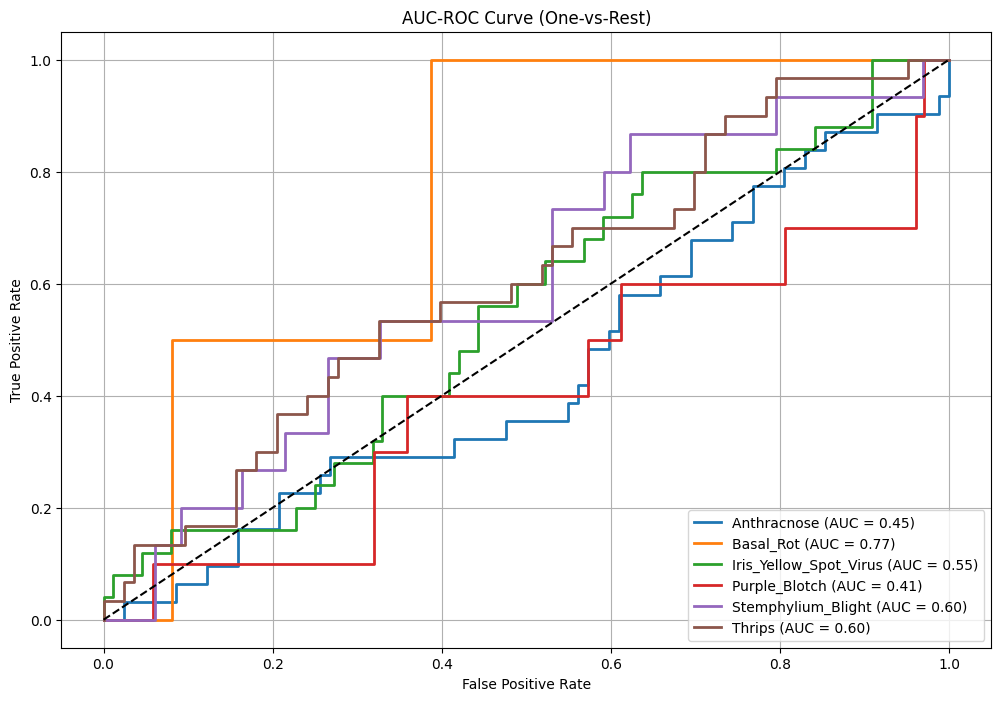

🧮 Macro-average AUC: 0.5606
🧮 Weighted-average AUC: 0.5318


In [ ]:
# STEP 10: Classification report, confusion matrix, and ROC AUC
import numpy as np

# Model size
model_size = sum([np.prod(v.shape) for v in model.trainable_variables])
model_size_MB = model_size * 4 / (1024 ** 2)  # 4 bytes per float32

print(f"\n✅ Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"✅ Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"⏱️ Training Time: {training_time:.2f} seconds")
print(f"📦 Model Size: {model_size_MB:.2f} MB")

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

plt.figure(figsize=(12, 8))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (One-vs-Rest)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Macro & weighted AUC
print(f"🧮 Macro-average AUC: {roc_auc_score(y_true_bin, y_pred, average='macro'):.4f}")
print(f"🧮 Weighted-average AUC: {roc_auc_score(y_true_bin, y_pred, average='weighted'):.4f}")
